In [1]:
# common imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas imports
from pandas.plotting import scatter_matrix

# machine learning imports
from sklearn.model_selection import train_test_split

# display setup
pd.set_option("display.max_columns", None) # the None parameter displays unlimited columns
sns.set(style="whitegrid") # for plots

## 1. Getting the Data

In [2]:
# read the csv file
df = pd.read_csv(r"hotel_bookings.csv")

In [3]:
# display the first 5 rows for a quick look
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
# DataFrame shape (rows, columns)
# understand the amount of data we are working with
df.shape

(119390, 32)

In [5]:
# description of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

> In a first observation it is clear that some features have
> missing values (i.e. "company" and "agent" columns).
> We will need to take care of this later.

In [6]:
# summary of the numerical attributes
# null values are ignored
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


> ### Features in the DataFrame:
>> 1. hotel: Resort Hotel or City Hotel
>> 2. is_canceled: Value indicating if the booking was canceled (1) or not (0)
>> 3. lead_time: Number of days between the booking date to the arrival date
>> 4. arrival_date_year: Year of arrival date
>> 5. arrival_date_month: Month of arrival date
>> 6. arrival_date_week_number: Week number according to year of arrival
>> 7. arrival_date_day_of_month: Day of arrival date
>> 8. stays_in_weekend_nights: Number of weekend nights booked (Saturday or Sunday)
>> 9. stays_in_week_nights: Number of week nights booked (Monday to Friday)
>> 10. adults: Number of adults
>> 11. children: Number of children
>> 12. babies: Number of babies
>> 13. meal: Type of meal
>> 14. country: Country of origin
>> 15. market_segment: Market segment designation, typically influences the price sensitivity
>> 16. distribution_channel: Booking distribution channel, refers to how the booking was made
>> 17. is_repeated_guest: Value indication if booking name was from a repeated guest (1) or not (0)
>> 18. previous_cancellations: Number of previous cancellations prior to current booking
>> 19. previous_bookings_not_canceled: Number of previous booking not canceled prior to current booking
>> 20. reserved_room_type: Code of room type reserved
>> 21. assigned_room_type: Code for the type of room assigned to the booking
>> 22. booking_changes: Number of changes made to the booking since entering the hotel management system
>> 23. deposit_type: Type of deposit made for the reservation
>> 24. agent: ID of the travel agency that made the booking
>> 25. company: ID of the company/organization that made the booking or is responsible for payment
>> 26. days_in_waiting_list: Number of days booking was in the waiting list until it was confirmed
>> 27. customer_type: Type of booking
>> 28. adr: Average Daily Rate (the sum of transactions divided by the number of nights stayed)
>> 29. required_car_parking_spaces: Number of car parking spaces requested
>> 30. total_of_special_requests: Number of special requests made by the customer
>> 31. reservation_status: Last reservation status (Canceled, Check-Out, No-Show)
>> 32. reservation_status_date: Date at which the last status was set
>>
>>> ##### *Understanding the features could help gain insight on how to treat null values.*

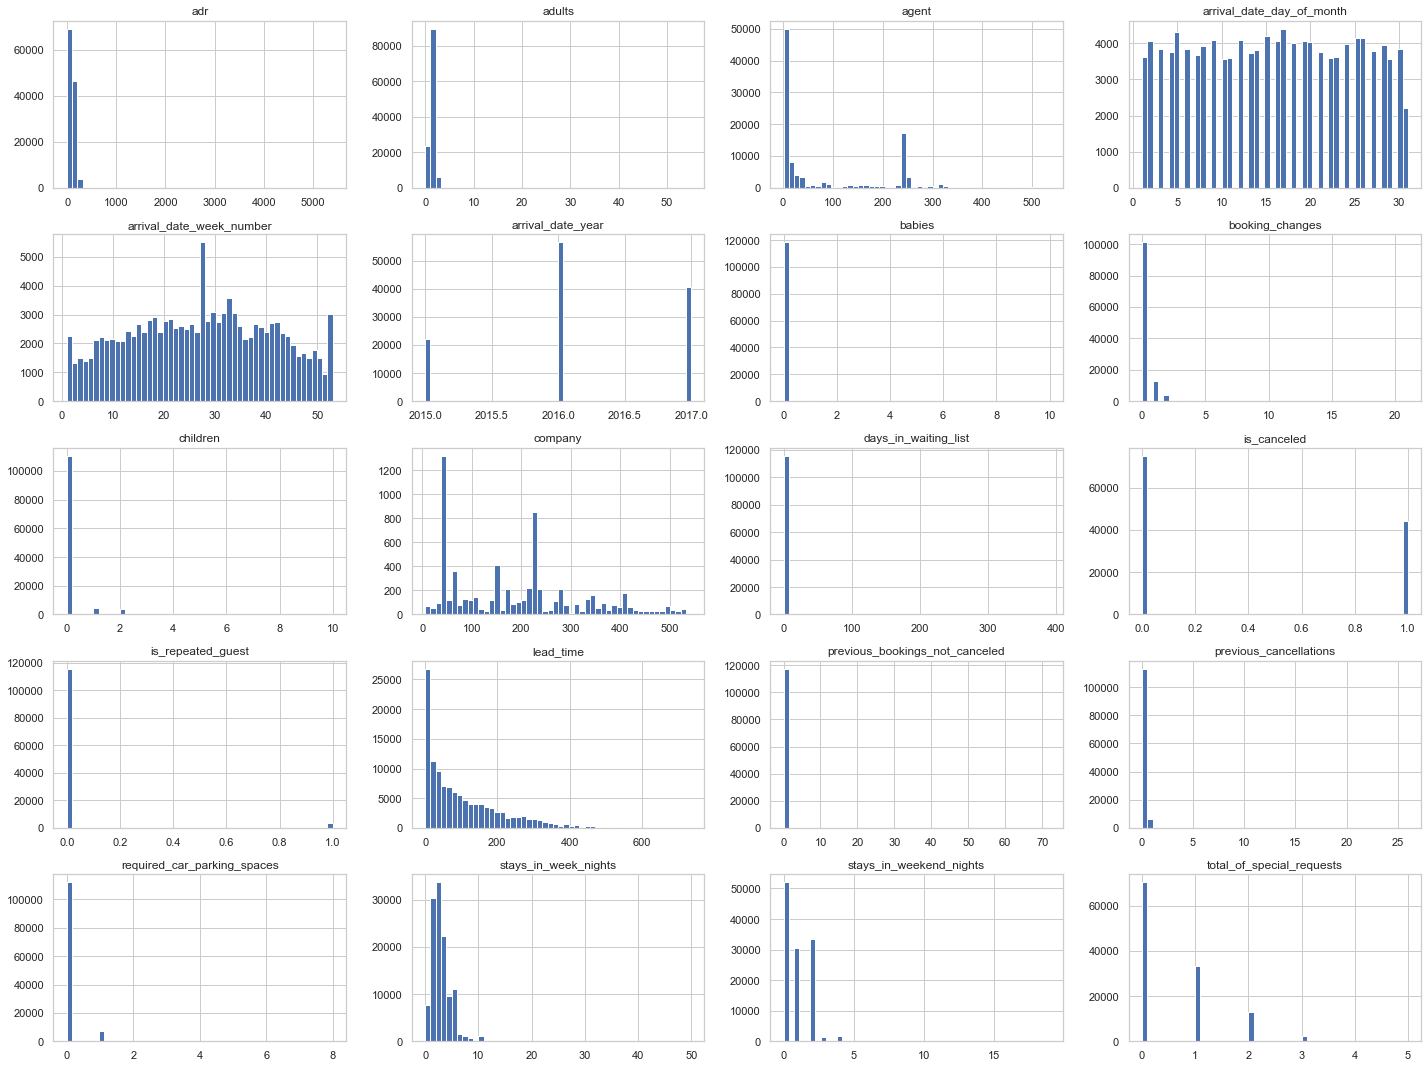

In [7]:
# a histogram plot for each numerical attribute
df.hist(bins=50, figsize=(20,15))
plt.tight_layout()
plt.show()

> Initial observations from the histograms:
>> 1. Some weeks have more bookings. This could be because of holiday or summer seasons, when people tend to travel more.
>> 2. According to the lead_time plot most bookings were made shortly before arrival.
>> 3. Booking tend to be without children or babies.
>> 4. It seems that the most accommodations are two weeks long or shorter.
>> 5. While most bookings were not canceled, there are thousands of instances that were.

> # Objective:
> ## Predicting if a booking will be canceled.
>> ### Chosen Feature:
>> #### *is_canceled* column
>>> 0 means the booking was not canceled
>>>
>>> 1 means the booking was canceled
>> ### Motive:
>> Like any business, hotels are also looking to gain profit. A model that predicts if the booking
>> is likely to be canceled could be a good indication for hotels, as they
>> may prefer to accept the lower risk bookings first.

> ### Missing Features:

In [8]:
# the methods below calculate the number of missing values
missing_values = df.isna().sum()
missing_values = missing_values[missing_values != 0]
missing_values

children         4
country        488
agent        16340
company     112593
dtype: int64

In [9]:
# replace missing values

# can assume that there were no children
df.fillna({"children": 0}, inplace=True)

# missing countries can be labeled unknown
df.fillna({"country": "Unknown"}, inplace=True)

# missing agent ID can be zero, likely booked privately
df.fillna({"agent": 0}, inplace=True)

# missing company ID can be zero, likely personal booking
df.fillna({"company": 0}, inplace=True)

In [10]:
# check that the values were filled
df.isna().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

In [11]:
# use sklearn train_test_split function to split the data
# the reason for selecting 0.15 as the test size is because the dataset is very large
# the random state parameter ensures that data will be shuffled and split the same way in each run
train_set, test_set = train_test_split(df, test_size=0.15, random_state=42)

In [12]:
print("Number of instances in training set: ", len(train_set))
print("Number of instances in testing set: ", len(test_set))

Number of instances in training set:  101481
Number of instances in testing set:  17909


## 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [13]:
# deep copy of the training set
df2 = train_set.copy()

In [14]:
df2.head(2)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
24840,Resort Hotel,0,156,2016,May,23,30,1,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,241.0,0.0,0,Transient,52.36,0,1,Check-Out,2016-06-05
6904,Resort Hotel,0,292,2016,July,29,10,1,0,2,0.0,0,BB,ISR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,72.90,1,2,Check-Out,2016-07-11


> ### Numerical Attributes:

In [15]:
# method creates a correlations matrix
corr_matrix = df2.corr()

In [16]:
# looking at attributes correlation with is_canceled feature
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.292182
previous_cancellations            0.109883
adults                            0.059744
days_in_waiting_list              0.053068
adr                               0.046790
stays_in_week_nights              0.027764
arrival_date_year                 0.017365
arrival_date_week_number          0.007757
children                          0.006771
stays_in_weekend_nights          -0.000019
arrival_date_day_of_month        -0.006062
babies                           -0.034658
agent                            -0.046444
previous_bookings_not_canceled   -0.055847
company                          -0.082484
is_repeated_guest                -0.084179
booking_changes                  -0.142916
required_car_parking_spaces      -0.195675
total_of_special_requests        -0.233580
Name: is_canceled, dtype: float64

In [17]:
# experimenting with attribute combinations

# adds column with total amount of guests that stayed
df2["guests_stayed"] = df2["adults"] + df2["children"] + df2["babies"]

# adds column with total nights stayed
df2["nights_stayed"] = df2["stays_in_week_nights"] + df2["stays_in_weekend_nights"]

In [18]:
# looking at the correlation matrix again with the added columns
corr_matrix = df2.corr()
corr_matrix["is_canceled"].sort_values(ascending=False)

is_canceled                       1.000000
lead_time                         0.292182
previous_cancellations            0.109883
adults                            0.059744
days_in_waiting_list              0.053068
adr                               0.046790
guests_stayed                     0.046693
stays_in_week_nights              0.027764
nights_stayed                     0.020709
arrival_date_year                 0.017365
arrival_date_week_number          0.007757
children                          0.006771
stays_in_weekend_nights          -0.000019
arrival_date_day_of_month        -0.006062
babies                           -0.034658
agent                            -0.046444
previous_bookings_not_canceled   -0.055847
company                          -0.082484
is_repeated_guest                -0.084179
booking_changes                  -0.142916
required_car_parking_spaces      -0.195675
total_of_special_requests        -0.233580
Name: is_canceled, dtype: float64

> ### Correlations with is_canceled Attribute - Overview:
> The strongest positive correlations (0.1 or more) are:
> * lead_time
> * previous_cancellations
>
> The strongest negative correlations (-0.1 or less) are:
> * total_of_special_requests
> * required_car_parking_spaces
> * booking_changes
>
> The attribute combinations tested (guests stayed and nights stayed) both had weak correlations.

> ### Cancellations According to Lead Time:

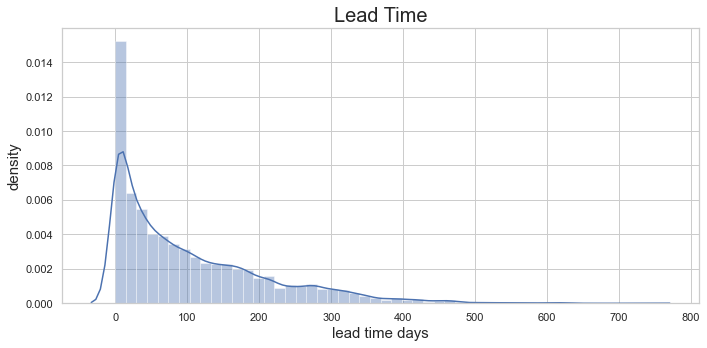

In [19]:
# density plot of lead time
# shows the distribution and highest concentration points
plt.figure(figsize=(10,5))
lead_time = df2['lead_time']
lead_time = pd.DataFrame(sorted(lead_time, reverse = True), columns = ['Lead'])
sns.distplot(lead_time)
plt.title("Lead Time", size=20)
plt.xlabel("lead time days", size=15)
plt.ylabel("density", size=15)
plt.tight_layout()
plt.show()

In [20]:
# divides lead time by less than 100 days, 100-355 days and 365 or more days
lead_time_1 = df2[df2["lead_time"] < 100]
lead_time_2 = df2[(df2["lead_time"] >= 100) & (df2["lead_time"] < 365)]
lead_time_3 = df2[df2["lead_time"] >= 365]

In [21]:
# calculates cancellations according to lead time groups
lead_cancel_1 = lead_time_1["is_canceled"].value_counts()
lead_cancel_2 = lead_time_2["is_canceled"].value_counts()
lead_cancel_3 = lead_time_3["is_canceled"].value_counts()

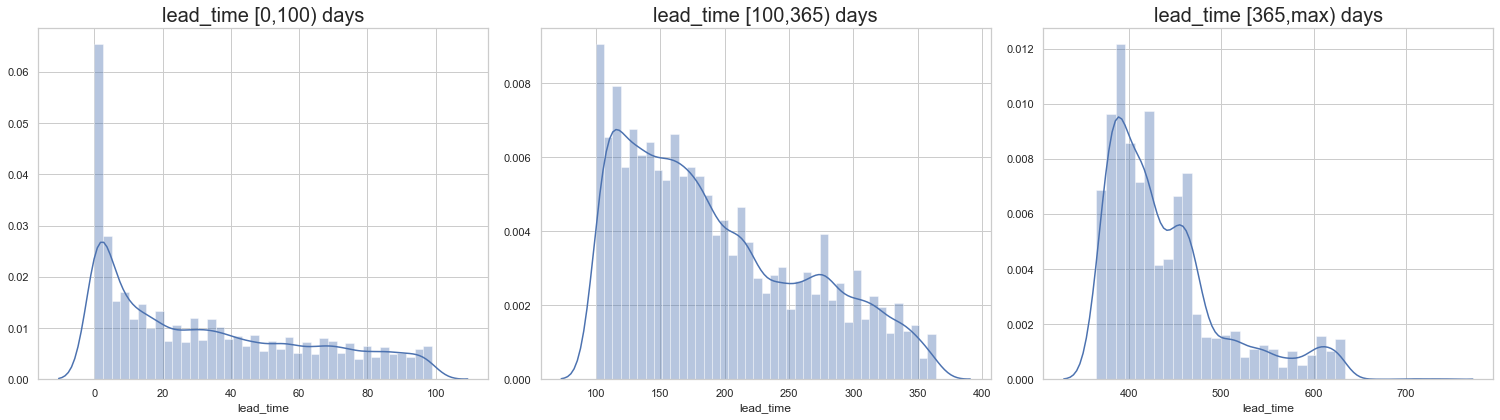

In [22]:
# density plot for each lead time group
fig, bx = plt.subplots(1,3,figsize=(21,6))
sns.distplot(lead_time_1["lead_time"], ax = bx[0])
bx[0].set_title("lead_time [0,100) days", size=20)
sns.distplot(lead_time_2["lead_time"], ax = bx[1])
bx[1].set_title("lead_time [100,365) days", size=20)
sns.distplot(lead_time_3["lead_time"], ax = bx[2])
bx[2].set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

In [23]:
# total count of lead time according to cancellation
total_lead_days_cancel = pd.DataFrame(data=[lead_cancel_1,lead_cancel_2,lead_cancel_3],
             index=["[0,100) days", "[100,365) days", "[365,max) days"])
total_lead_days_cancel

,0,1
"[0,100) days",44163,16828
"[100,365) days",19013,18746
"[365,max) days",873,1858


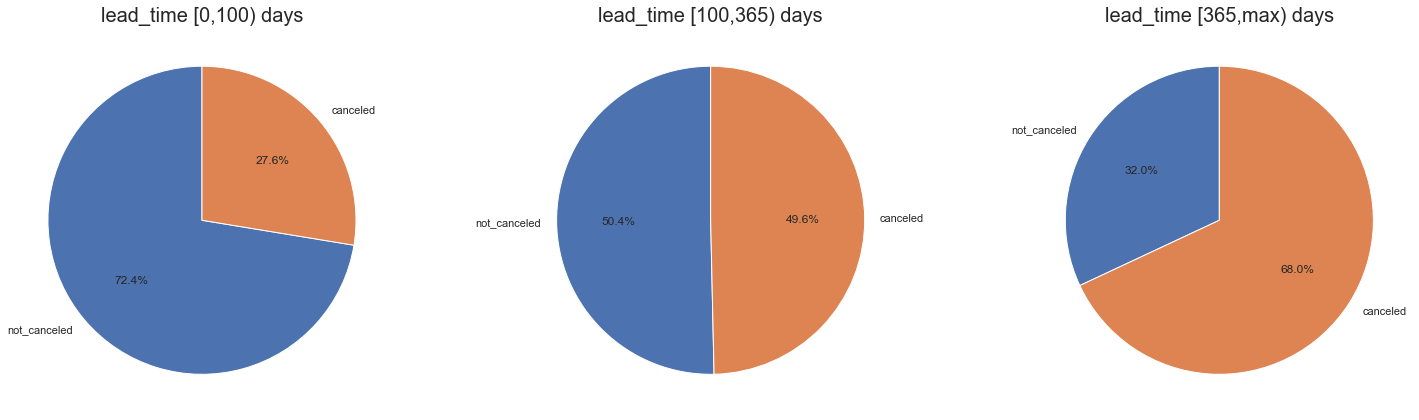

In [24]:
fig, ax = plt.subplots(1,3, figsize=(21,6))
ax[0].pie(np.array([total_lead_days_cancel[0][0], total_lead_days_cancel[1][0]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90)
ax[0].set_title("lead_time [0,100) days", size=20)
ax[1].pie(np.array([total_lead_days_cancel[0][1], total_lead_days_cancel[1][1]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90)
ax[1].set_title("lead_time [100,365) days", size=20)
ax[2].pie(np.array([total_lead_days_cancel[0][2], total_lead_days_cancel[1][2]]),
          labels=["not_canceled", "canceled"], autopct='%1.1f%%', startangle=90)
ax[2].set_title("lead_time [365,max) days", size=20)
plt.tight_layout()
plt.show()

> #### Observations:
>> * Most bookings occur about 5 days prior to arrival.
>> * When the lead time is larger the chances for cancellation increase.
>> * The amount of bookings is steady overall between 20-100 days, then drops.

> ### Cancellations According to Previous Cancellations:

In [25]:
# gets previous cancellation column
prev_cancel = df2["previous_cancellations"]

In [26]:
# sorts index values
prev_cancel.value_counts().sort_index()

0     96001
1      5112
2       101
3        48
4        29
5        15
6        22
11       30
13        8
14       11
19       17
21        1
24       45
25       20
26       21
Name: previous_cancellations, dtype: int64

In [27]:
print("Cancellation Rates:\n")
print('Never canceled =' ,str(round(df2[df2['previous_cancellations']==0]
                                            ['is_canceled'].mean()*100,2))+' %')
print('Canceled once =' ,str(round(df2[df2['previous_cancellations']==1]
                                            ['is_canceled'].mean()*100,2))+' %')
print('Canceled more than 10 times:',str(round(df2[df2['previous_cancellations']>10]
                                            ['is_canceled'].mean()*100,2))+' %')
print('Canceled more than 11 times:' ,str(round(df2[df2['previous_cancellations']>11]
                                            ['is_canceled'].mean()*100,2))+' %')

Cancellation Rates:

Never canceled = 33.76 %
Canceled once = 94.37 %
Canceled more than 10 times: 85.62 %
Canceled more than 11 times: 99.19 %


In [28]:
# creates a list with previous cancellations indices
prev_cancel_index = df2["previous_cancellations"].value_counts().index.to_list()
# sorts the list
prev_cancel_index.sort()

# calculates the average percentage of cancellations for each value in DataFrame
percentage_prev_cancel= []
for i in prev_cancel_index:
    percentage_prev_cancel.append((round(df2[df2["previous_cancellations"]==i]
                                        ["is_canceled"].mean()*100,2)))
percentage_prev_cancel

[33.76,
 94.37,
 33.66,
 29.17,
 24.14,
 13.33,
 31.82,
 30.0,
 87.5,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0]

In [29]:
# creates a DataFrame with the results
df_prev_cancel = pd.DataFrame(percentage_prev_cancel, index=prev_cancel_index, columns=["Previous Cancellations %"])
df_prev_cancel

,Previous Cancellations %
0,33.76
1,94.37
2,33.66
3,29.17
4,24.14
5,13.33
6,31.82
11,30.00
13,87.50
14,100.00


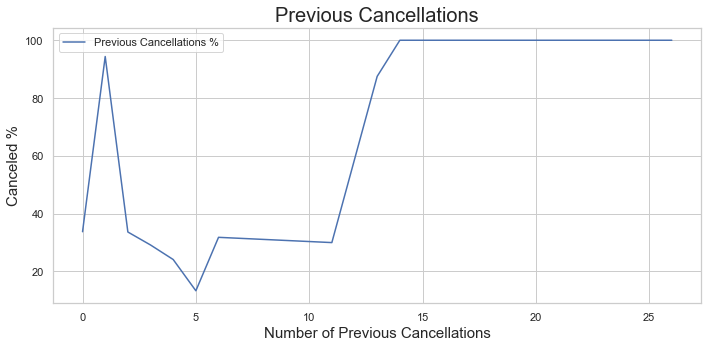

In [46]:
# plots previous cancellations by percentages
df_prev_cancel.plot(figsize= (10,5))
plt.title("Previous Cancellations", size=20)
plt.xlabel("Number of Previous Cancellations", size=15)
plt.ylabel("Canceled %", size=15)
plt.tight_layout()
plt.show()

> ### Observations:
>> The percentages show that when there are more previous cancellations, there is
>> a substantially higher chance the customer will cancel again.